## Table of Contents

1. [Installation](#install)
2. [Imports](#imports)
3. [Bag of Visual Words](#bovw)
    1. [Bag of Visual Words Utils](#bovw_util)
    2. [Training and Data Prepration](#bovw_train)
    3. [Testing and Data Prepration](#bovw_test)


## Installation <a name="install"></a>

In [1]:
! pip uninstall opencv-python -y
! pip uninstall opencv-contrib-python -y
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45
! pip install tqdm

Found existing installation: opencv-python 4.5.3.56
Uninstalling opencv-python-4.5.3.56:
  Successfully uninstalled opencv-python-4.5.3.56


## Imports <a name="imports"></a>

In [1]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

## Util Functions

In [2]:
def show(img):
    io.imshow(img)
    plt.show()

## Bag of Visual Words <a name="bovw"></a>

![Bag of Visual Words](https://miro.medium.com/max/625/1*QgI1t-7yJApi4vQigFgsLQ.jpeg "Title")

Bag of Visual Words Algorithm Steps:
- Feature Extraction
![Feature Extraction](https://miro.medium.com/max/1834/1*68DDbQ2ypiazborJl5E2lA.png "Feature Extraction")

- Quantization of Feature Space
![Quantization of Feature Space](https://miro.medium.com/max/1198/1*ge_bVqseHxmmb57xXIOJag.jpeg "Quantization of Feature Space")

- Extaction of Local Features
![Extaction of Local Features](https://miro.medium.com/max/600/1*eyVNGqEpqu6Q8Z-HGp39oQ.jpeg "Extaction of Local Features")

- Creation of Histogram


Reference : https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f

In [3]:
import os
import random
import pandas as pd
import numpy as np
from shutil import copyfile

data_dir='../Desktop/flower'
print(len(os.listdir(data_dir+'/daisy/')))
print(len(os.listdir(data_dir+'/dandelion/')))
print(len(os.listdir(data_dir+'/roses/')))
print(len(os.listdir(data_dir+'/sunflowers/')))
print(len(os.listdir(data_dir+'/tulips/')))

88
88
77
77
77


In [4]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)

source_path=[f'../Desktop/flower/{a}' for a in classes]
print(source_path)

classes_dir=[f'{a}_dir' for a in classes]
classes_dir

for cl_dir,cl_path in zip(classes_dir,source_path):
    print(cl_dir,': ',len(os.listdir(cl_path)))

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['../Desktop/flower/daisy', '../Desktop/flower/dandelion', '../Desktop/flower/roses', '../Desktop/flower/sunflowers', '../Desktop/flower/tulips']
daisy_dir :  88
dandelion_dir :  88
roses_dir :  77
sunflowers_dir :  77
tulips_dir :  77


In [5]:
print (os.getcwd())

try:
    os.mkdir('../Desktop/flower/training')
    os.mkdir('../Desktop/flower/testing')
except OSError:
    pass

C:\Users\saad\Desktop


In [6]:
TRAINING_PATH='../Desktop/flower/training'

training_dir_path=[f'../Desktop/flower/training/{a}' for a in classes]
print('\n',training_dir_path)

testing_dir_path=[f'../Desktop/flower/testing/{a}' for a in classes]
print('\n',testing_dir_path)


 ['../Desktop/flower/training/daisy', '../Desktop/flower/training/dandelion', '../Desktop/flower/training/roses', '../Desktop/flower/training/sunflowers', '../Desktop/flower/training/tulips']

 ['../Desktop/flower/testing/daisy', '../Desktop/flower/testing/dandelion', '../Desktop/flower/testing/roses', '../Desktop/flower/testing/sunflowers', '../Desktop/flower/testing/tulips']


In [7]:
for train_dir_path in training_dir_path:
    try:
        os.mkdir(train_dir_path)
    except OSError:
        pass
    
for test_dir_path in testing_dir_path:
    try:
        os.mkdir(test_dir_path)
    except OSError:
        pass

In [8]:
# def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE): #for VALIDATION
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    print('Split Data')
    for filename in os.listdir(SOURCE):
        file = SOURCE +'/'+ filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int( len(files)* SPLIT_SIZE)
#     validation_length = int(len(files) * 0.10)
    testing_length = int(len(files) - training_length)
#     testing_length = int(len(files) - training_length - validation_length)
    
    print('SOURCE: ',SOURCE, '\n TRAINING', TRAINING, '\n ',len(files))
#     print('SOURCE: ',SOURCE, '\n TRAINING', TRAINING, '\n VALIDATION',VALIDATION, '\n ',len(files))
    print('training_length:',training_length)
#     print('validation_length:',validation_length)
    print('testing_length:',testing_length)
    
#     shuffled_set = random.sample(files, len(files))
    training_set = files[0:training_length]
#     validation_set = files[training_length:(training_length+validation_length)]
#     testing_set=files[:testing_length]
    testing_set=files[training_length:training_length+testing_length]
    print(len(training_set))
#     print(len(validation_set))
    print(len(testing_set))
    
    for filename in training_set:
        this_file = SOURCE +'/'+ filename
        destination = TRAINING +'/'+ filename
        copyfile(this_file, destination)
    

#     for filename in validation_set:
#         this_file = SOURCE +'/'+ filename
#         destination = VALIDATION+'/' + filename
#         copyfile(this_file, destination)
        
    for filename in testing_set:
        this_file = SOURCE +'/'+ filename
        destination = TESTING+'/' + filename
        copyfile(this_file, destination)

In [9]:
split_size = .80
for source,train_dir_path,test_dir_path in zip(source_path,\
                                training_dir_path, testing_dir_path):
    #print('source: ',source,'\n', train_dir_path,'\n',val_dir_path,'\n')
    split_data(source,train_dir_path,test_dir_path, split_size)
    print('Splitting \n')

Split Data
SOURCE:  ../Desktop/flower/daisy 
 TRAINING ../Desktop/flower/training/daisy 
  88
training_length: 70
testing_length: 18
70
18
Splitting 

Split Data
SOURCE:  ../Desktop/flower/dandelion 
 TRAINING ../Desktop/flower/training/dandelion 
  88
training_length: 70
testing_length: 18
70
18
Splitting 

Split Data
SOURCE:  ../Desktop/flower/roses 
 TRAINING ../Desktop/flower/training/roses 
  77
training_length: 61
testing_length: 16
61
16
Splitting 

Split Data
SOURCE:  ../Desktop/flower/sunflowers 
 TRAINING ../Desktop/flower/training/sunflowers 
  77
training_length: 61
testing_length: 16
61
16
Splitting 

Split Data
SOURCE:  ../Desktop/flower/tulips 
 TRAINING ../Desktop/flower/training/tulips 
  77
training_length: 61
testing_length: 16
61
16
Splitting 



### Bag of Visual Words Utils <a name="bovw_util"></a>

In [10]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42))
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

### Training and Data Prepration <a name="bovw_train"></a>

In [11]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)
    for img_path in images:
        if("daisy" in img_path):
            class_index = 0
        elif("dandelion" in img_path):
            class_index = 1
        elif("roses" in img_path):
            class_index = 2
        elif("sunflowers" in img_path):
            class_index = 3
        elif("tulips" in img_path):
            class_index = 4

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


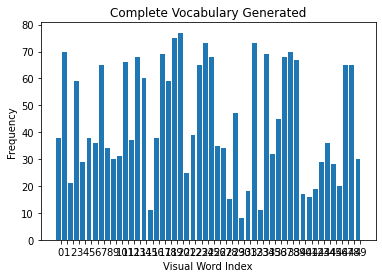

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
--- 3752.3372497558594 seconds ---


In [12]:
train_path = "../Desktop/flower/training"
test_path = "../Desktop/flower/testing"
no_clusters = 50
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
# save the model to disk
import joblib
filename = 'finalized_model.sav'
joblib.dump(svm, filename)

### Testing and Data Prepration <a name="bovw_test"></a>

In [13]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "daisy",
        "1": "dandelion",
        "2": "roses",
        "3": "sunflowers",
        "4": "tulips"
    }
    

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("daisy" in img_path):
                true.append("daisy")
            elif("dandelion" in img_path):
                true.append("dandelion")
            elif("roses" in img_path):
                true.append("roses")
            elif("sunflowers" in img_path):
                true.append("sunflowers")
            else:
                true.append("tulips")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[ 7  1  1  4  5]
 [ 2  3  2  4  7]
 [ 3  2  4  1  6]
 [ 1  1  0 11  3]
 [ 0  3  3  0 10]]
Normalized confusion matrix
[[0.39 0.06 0.06 0.22 0.28]
 [0.11 0.17 0.11 0.22 0.39]
 [0.19 0.12 0.25 0.06 0.38]
 [0.06 0.06 0.   0.69 0.19]
 [0.   0.19 0.19 0.   0.62]]


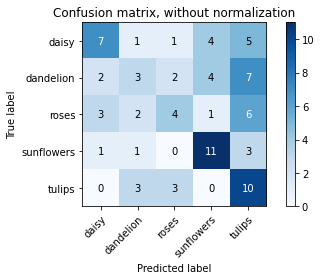

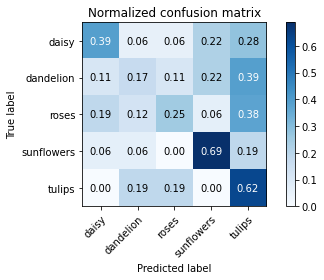

Confusion matrixes plotted.
accuracy score: 0.417
Accuracy calculated.
Execution done.
--- 977.7871150970459 seconds ---


In [14]:
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

#### References
Splitting Data Folders into Training, Validation and Testing Folders using Shuffling with Python and scikit-learn
https://medium.com/@Ana_Caballero_H/splitting-data-folders-into-training-validation-and-testing-folders-using-shuffling-with-python-63cabcd997dd <br>

In [15]:
# save the model to disk
import joblib
filename = 'finalized_model.sav'
joblib.dump(svm, filename)

['finalized_model.sav']